# Implied term structures

(Based on [a question](http://quant.stackexchange.com/questions/9589/) by _Stack Exchange_ user Lisa Ann. Thanks!)

In [1]:
from QuantLib import *

In [2]:
%matplotlib inline
import pandas as pd
import utils
from utils import to_datetime, format_rate

from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import FuncFormatter
def plot_curve(*curves):
    fig, ax = utils.plot()
    dates = [ today+Period(i,Weeks) for i in range(0, 52*5) ]
    for (c, style) in curves:
        valid_dates = [ d for d in dates if d >= c.referenceDate() ]
        rates = [ c.forwardRate(d, d+1, Actual360(), Simple).rate()
                  for d in valid_dates ]
        ax.plot_date([ to_datetime(d) for d in valid_dates ], rates, style)
    ax.set_xlim(to_datetime(min(dates)),to_datetime(max(dates)))
    ax.xaxis.set_major_locator(MonthLocator(bymonth=[6,12]))
    ax.xaxis.set_major_formatter(DateFormatter("%b '%y"))
    ax.xaxis.grid(True, 'major')
    ax.xaxis.grid(False, 'minor')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda r,pos: format_rate(r)))

#### The statement of the case

Let's say we have an interest-rate curve. For the sake of example, I'll take a simple one bootstrapped on a few swap rates.

In [3]:
today = Date(9,March,2016)
Settings.instance().evaluationDate = today

In [4]:
helpers = [ SwapRateHelper(QuoteHandle(SimpleQuote(rate/100.0)),
                           Period(*tenor), TARGET(),
                           Annual, Unadjusted, 
                           Thirty360(), 
                           Euribor6M())
            for tenor, rate in [((6,Months), 0.201),
                                ((2,Years), 0.258),
                                ((5,Years), 0.464),
                                ((10,Years), 1.151),
                                ((15,Years), 1.588)] ]
curve = PiecewiseLinearZero(0, TARGET(), helpers, Actual360())

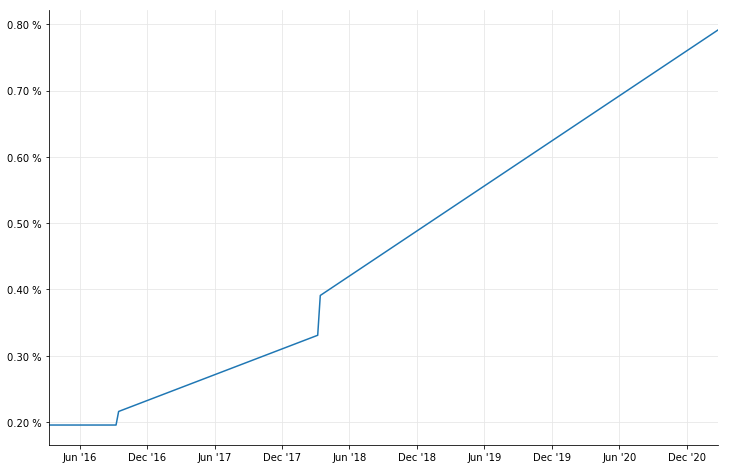

In [5]:
plot_curve((curve, '-'))

I'm using linear interpolation on the zero rates, which isn't great for actual use. However, the resulting jumps in the forward rates will be useful as visual points of reference; note, for instance, the jump around March 2018.

The curve also implies an interest-rate curve in 1 year; meaning that, for instance, it can give us the forward rate between 1 and to 2 years, that we expect to be the 1-year spot rate one year from now, or the forward rate between 1 year and 18 months, which will be the 6-months spot rate in one year.  The implied curve can be built as an instance of the `ImpliedTermStructure` class:

In [6]:
future_reference = today + Period(1,Years)
implied_curve = ImpliedTermStructure(YieldTermStructureHandle(curve),
                                     future_reference)

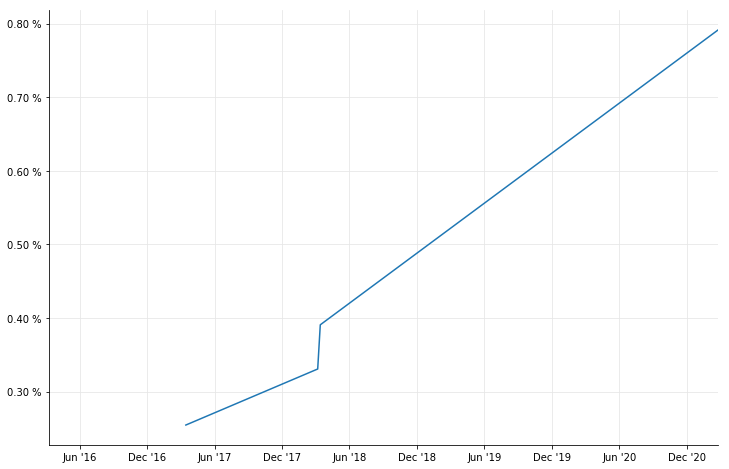

In [7]:
plot_curve((implied_curve, '-'))

In the common range, the two curves are the same...

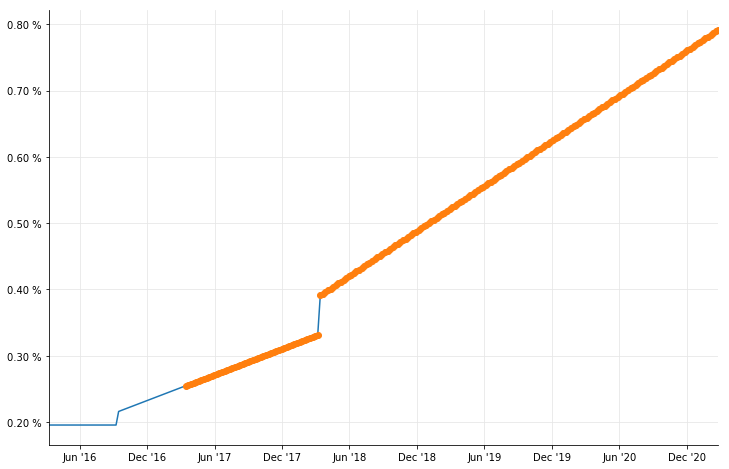

In [8]:
plot_curve((curve, '-'), (implied_curve, 'o'))

...although, of course, a spot rate for the implied curve corresponds to a forward rate for the original curve.

In [9]:
dates = [ future_reference + Period(i, Years) for i in range(6) ]
rates_1 = [ curve.forwardRate(future_reference, d,
                              Actual360(), Continuous).rate()
            for d in dates ]
rates_2 = [ implied_curve.zeroRate(d, Actual360(), Continuous).rate()
            for d in dates ]
pd.DataFrame(list(zip(dates,
                      [ format_rate(r) for r in rates_1 ],
                      [ format_rate(r) for r in rates_2 ])),
             columns=('Maturity', 'Original forward rate',
                      'Implied zero rate'), index=['']*6)

,Maturity,Original forward rate,Implied zero rate
,"March 9th, 2017",0.25 %,0.25 %
,"March 9th, 2018",0.29 %,0.29 %
,"March 9th, 2019",0.37 %,0.37 %
,"March 9th, 2020",0.45 %,0.45 %
,"March 9th, 2021",0.52 %,0.52 %
,"March 9th, 2022",0.67 %,0.67 %


Now, Lisa Ann's idea was to forecast a bond price as of one year from now based on the implied curve. In the library framework, that means setting the evaluation date to 1 year from today and using the implied curve to discount the bond cash flows. However, after changing the evaluation date...

In [10]:
Settings.instance().evaluationDate = future_reference

...the implied curve had changed.

In [11]:
rates_3 = [ implied_curve.zeroRate(d, Actual360(), Continuous).rate()
            for d in dates ]
pd.DataFrame(list(zip(dates,
                      [ format_rate(r) for r in rates_2 ],
                      [ format_rate(r) for r in rates_3 ])),
             columns=('Maturity', 'Before date change',
                      'After date change'), index=['']*6)

,Maturity,Before date change,After date change
,"March 9th, 2017",0.25 %,0.20 %
,"March 9th, 2018",0.29 %,0.22 %
,"March 9th, 2019",0.37 %,0.25 %
,"March 9th, 2020",0.45 %,0.32 %
,"March 9th, 2021",0.52 %,0.39 %
,"March 9th, 2022",0.67 %,0.46 %


#### What happened?

Simply put: the reference date of the original curve was specified relative to the evaluation date, and when we moved it the curve moved, too. Let's try it:

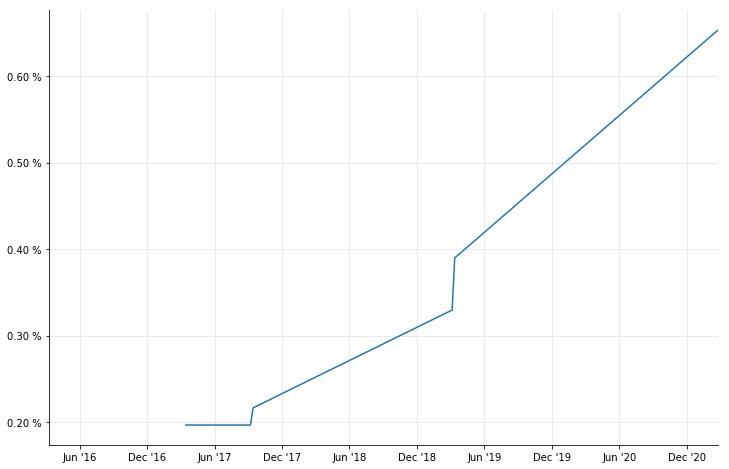

In [12]:
Settings.instance().evaluationDate = future_reference
plot_curve((curve, '-'))

Remember that jump in March 2018? It's in March 2019 now.

Thus, after moving the evaluation date, the original and implied curve are exactly the same; and the spot rates returned by the implied curve are no longer forward rates, but the spot rates returned by the original curve.

In [13]:
rates_1 = [ curve.zeroRate(d, Actual360(), Continuous).rate()
            for d in dates ]
rates_2 = [ implied_curve.zeroRate(d, Actual360(), Continuous).rate()
            for d in dates ]
pd.DataFrame(list(zip(dates,
                      [ format_rate(r) for r in rates_1 ],
                      [ format_rate(r) for r in rates_2 ])),
             columns=('Maturity', 'Original zero rate',
                      'Implied zero rate'), index=['']*6)

,Maturity,Original zero rate,Implied zero rate
,"March 9th, 2017",0.20 %,0.20 %
,"March 9th, 2018",0.22 %,0.22 %
,"March 9th, 2019",0.25 %,0.25 %
,"March 9th, 2020",0.32 %,0.32 %
,"March 9th, 2021",0.39 %,0.39 %
,"March 9th, 2022",0.46 %,0.46 %


The solution would be to build the original curve so that it doesn't move when the evaluation date changes; and as you might remember, the way to do that is to specify a reference date explicitly. 

Unfortunately, though, doing this to a bootstrapped curve is an open issue; even if we specified the reference date, the underlying swaps would still move (it's a long story). Thus, the actual solution will be a bit of a kludge: we'll make a frozen copy of the original curve that doesn't move when the evaluation date does. The way we do it is to return to the original evaluation date...

In [14]:
Settings.instance().evaluationDate = today

...extract the bootstrapped rates...

In [15]:
curve.nodes()

((Date(9,3,2016), 0.001954693606572509),
 (Date(12,9,2016), 0.001954693606572509),
 (Date(12,3,2018), 0.002536800732553941),
 (Date(11,3,2021), 0.004572804156623578),
 (Date(11,3,2026), 0.011524783611804843),
 (Date(11,3,2031), 0.01615156507336212))

...and create a curve with the same rates and a fixed reference date.

In [16]:
node_dates, node_rates = zip(*curve.nodes())
frozen_curve = ZeroCurve(node_dates, node_rates, curve.dayCounter())

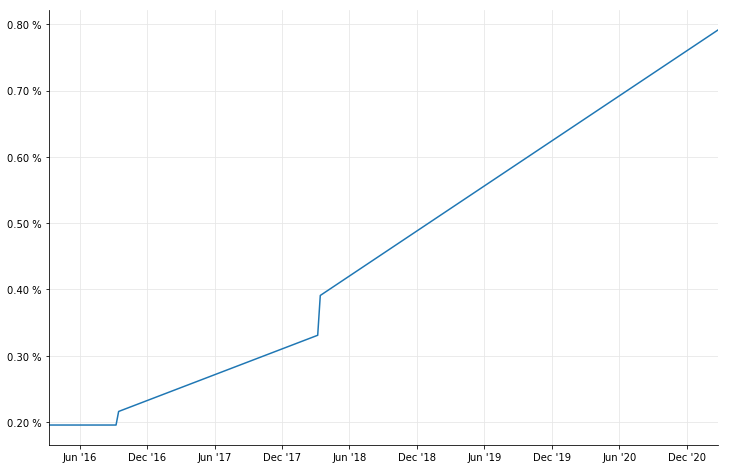

In [17]:
plot_curve((frozen_curve, '-'))

As I said, a bit of a kludge: this curve is a frozen copy, and won't react to changes in the underlying quoted swap rates, so you'd have to recreate it manually if you want to track the market as it moves.

However, now we can build the implied curve based on the frozen one:

In [18]:
implied_curve = ImpliedTermStructure(YieldTermStructureHandle(frozen_curve),
                                     future_reference)

If we move the evaluation date, the frozen curve remains fixed at today's date...

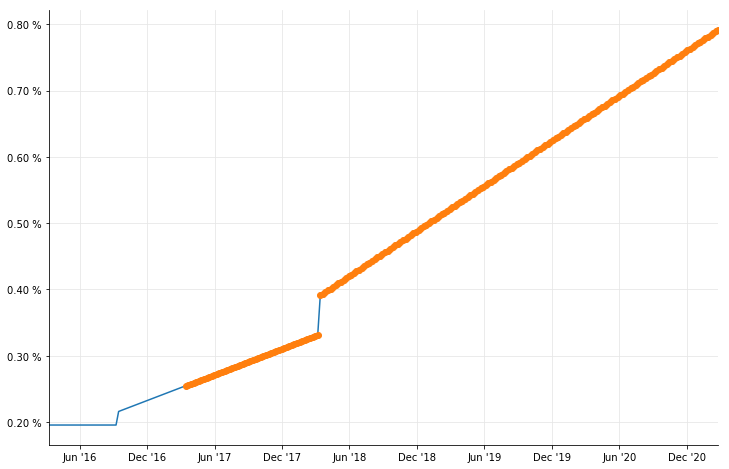

In [19]:
Settings.instance().evaluationDate = future_reference
plot_curve((frozen_curve,'-'), (implied_curve,'o'))

...and the implied curve returns the correct rates.

In [20]:
rates_1 = [ frozen_curve.zeroRate(d, Actual360(), Continuous).rate()
            for d in dates ]
rates_2 = [ frozen_curve.forwardRate(future_reference, d,
                                     Actual360(), Continuous).rate()
            for d in dates ]
rates_3 = [ implied_curve.zeroRate(d, Actual360(), Continuous).rate()
            for d in dates ]
pd.DataFrame(list(zip(dates,
                      [ format_rate(r) for r in rates_1 ],
                      [ format_rate(r) for r in rates_2 ],
                      [ format_rate(r) for r in rates_3 ])),
             columns=('Maturity', 'Original zero rate',
                      'Original forward rate', 'Implied zero rate'),
             index=['']*6)

,Maturity,Original zero rate,Original forward rate,Implied zero rate
,"March 9th, 2017",0.21 %,0.25 %,0.25 %
,"March 9th, 2018",0.25 %,0.29 %,0.29 %
,"March 9th, 2019",0.32 %,0.37 %,0.37 %
,"March 9th, 2020",0.39 %,0.45 %,0.45 %
,"March 9th, 2021",0.46 %,0.52 %,0.52 %
,"March 9th, 2022",0.60 %,0.67 %,0.67 %
